# Mapping the Extent of mCDR Signals within Finite Regional Domains

This notebook demonstrates how to map the extent of marine Carbon Dioxide Removal (mCDR) signals within finite regional domains. The analysis involves:

1. **Defining the regional model grid**: Creating a finite regional ocean model grid using ROMS tools
2. **Loading the global atlas grid**: Using the POP ocean model grid as the base for the atlas dataset
3. **Identifying overlapping polygons**: Finding which atlas polygons intersect with the regional domain
4. **Integrating CO2 fluxes**: Computing cumulative CO2 uptake within the regional domain boundaries
5. **Visualizing results**: Mapping the fraction of CO2 uptake captured within the regional domain

The key challenge is determining what fraction of the global mCDR signal (from the atlas) is captured within a finite regional model domain, which is essential for understanding the efficiency and spatial extent of regional mCDR deployments.

## Step 1: Import Required Libraries

Load the necessary Python packages for data manipulation, grid handling, and analysis utilities.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr

import pop_tools
import roms_tools as rt

import util

/global/homes/m/mattlong/.conda/envs/atlas-calcs/lib/python3.13/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
ERROR 1: PROJ: proj_create_from_database: Open of /global/homes/m/mattlong/.conda/envs/atlas-calcs/share/proj failed


## Step 2: Load the Global Atlas Grid

Load the POP (Parallel Ocean Program) global ocean model grid (`POP_gx1v7`), which serves as the base grid for the atlas dataset. This grid provides the spatial coordinates (TLAT, TLONG) and cell areas (TAREA) needed for area-weighted calculations.

In [2]:
atlas_grid = pop_tools.get_grid(grid_name="POP_gx1v7")


## Step 3: Define the Regional Model Grid

Create a finite regional ocean model grid using ROMS (Regional Ocean Modeling System) tools. This grid defines the spatial boundaries of our regional domain. The grid parameters include:

- **Grid dimensions**: number of grid points
- **Physical size**: domain extent
- **Center location**: geographic center
- **Rotation**: grid rotation angle
- **Vertical levels**: number of vertical sigma levels

The grid is plotted to visualize the regional domain extent.

INFO - === Creating the horizontal grid ===
INFO - Total time: 0.269 seconds
INFO - ========================================================================================================
INFO - === Creating the mask ===
INFO - Total time: 0.511 seconds
INFO - ========================================================================================================
INFO - === Generating the topography using ETOPO5 data and hmin = 5.0 meters ===
INFO - Reading the topography data: 0.178 seconds
INFO - Regridding the topography: 0.019 seconds
INFO - Domain-wide topography smoothing: 0.023 seconds
INFO - Local topography smoothing: 4.467 seconds
INFO - Total time: 4.703 seconds
INFO - ========================================================================================================
INFO - === Preparing the vertical coordinate system using N = 100, theta_s = 6.0, theta_b = 6.0, hc = 250 ===
INFO - Total time: 0.005 seconds
INFO - =======================================================

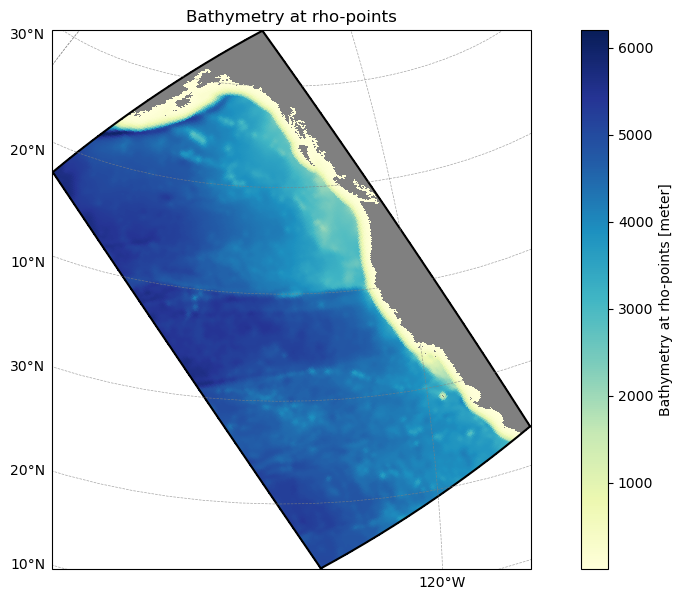

In [3]:
model_grid = rt.Grid(
    nx=224,
    ny=440,
    size_x=2688,
    size_y=5280,
    center_lon=-134.5,
    center_lat=39.6,
    rot=33.3,
    N=100,
    hc=250,
    theta_s=6.0,
    theta_b=6.0,
    verbose=True,
    hmin=5.0
)
model_grid.plot()

## Step 4: Load Polygon Masks

Load the polygon masks from the atlas dataset. Each polygon represents a distinct mCDR injection location. The polygon IDs are masked to only include ocean points (where `KMT > 0`, indicating valid ocean grid cells).

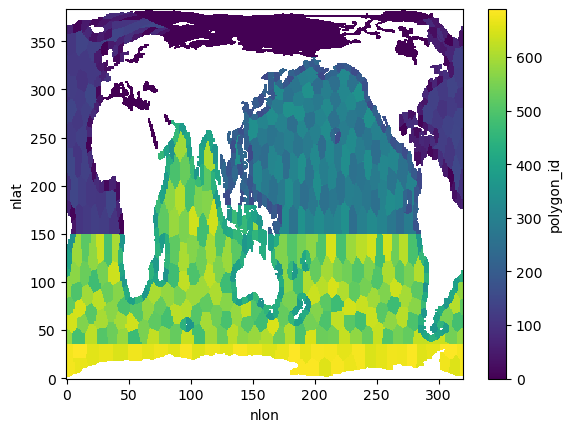

In [4]:
ds_atlas_polygons = xr.open_dataset("polygon_masks.nc")
polygon_ids = ds_atlas_polygons.polygon_id.where(atlas_grid.KMT > 0)
polygon_ids.plot()

## Step 5: Create Analyzer and Identify Overlapping Polygons

Initialize the `AtlasModelGridAnalyzer` class, which:

1. **Computes the convex hull** of the regional model grid using all lat/lon points from `model_grid.ds.lat_u` and `lon_u`
2. **Performs point-in-polygon tests** to identify which atlas grid points fall within the regional domain boundaries
3. **Extracts unique polygon IDs** that have at least some overlap with the regional domain
4. **Creates a polygon ID mask** where polygon IDs are set to -1 outside the regional domain

The analyzer uses a convex hull approach (rather than a simple bounding box) to accurately handle non-rectangular regional domains. The resulting mask shows which polygons intersect with the regional domain.p 

Found 34 unique polygon IDs within model grid boundaries
Polygon IDs: [152. 154. 159. 164. 167. 172. 180. 192. 194. 199. 201. 214. 219. 226.
 243. 244. 250. 259. 269. 270. 271. 276. 289. 290. 295. 299. 306. 320.
 324. 326. 328. 331. 345. 348.]


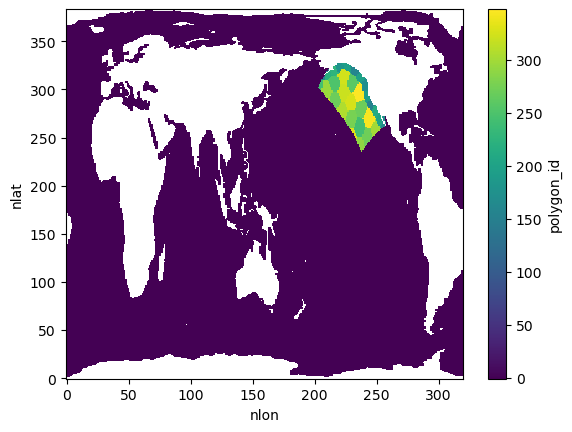

In [5]:
# Create AtlasModelGridAnalyzer instance
analyzer = util.AtlasModelGridAnalyzer(model_grid, atlas_grid, polygon_ids=polygon_ids)

# Get polygon IDs within model grid boundaries
print(f"Found {len(analyzer.polygon_ids_in_bounds)} unique polygon IDs within model grid boundaries")
print(f"Polygon IDs: {analyzer.polygon_ids_in_bounds[:100]}..." if len(analyzer.polygon_ids_in_bounds) > 100 else f"Polygon IDs: {analyzer.polygon_ids_in_bounds}")

analyzer.polygon_id_mask.plot(vmin=-1, vmax=analyzer.polygon_id_mask.max())

## Step 6: Test: Integrate CO<sub>2</sub> Flux for a Single Polygon

Compute the cumulative CO2 uptake for a single polygon over a 3-month period. The integration:

1. **Retrieves alk-forcing files** from S3 (with local caching) for the specified polygon, injection date, and time period
2. **Calculates the additional CO2 flux** (`FG_CO2_additional = FG_CO2 - FG_ALT_CO2`) which represents the mCDR signal
3. **Integrates over space and time** using:
   - Area weighting with `TAREA` (grid cell areas)
   - Time weighting with days per month converted to seconds
   - Spatial masking to restrict to points within the regional domain
4. **Computes cumulative integrals** over the elapsed time dimension

The results show:
- **Total integrated FG_CO2**: Total CO2 uptake over the entire polygon extent
- **Within model grid**: CO2 uptake within the regional domain boundaries
- **Fraction within grid**: Percentage of total uptake captured by the regional domain

In [6]:
years = [347+i for i in range(15)]
years

[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361]

In [7]:
cluster = util.dask_cluster(account="m4632", wallclock="06:00:00")
cluster

spinning up dask cluster with scheduler:
  /pscratch/sd/m/mattlong/dask/dask_scheduler_file.zer1d22g.json
cluster running...
Dashboard:
 https://jupyter.nersc.gov//user/mattlong/perlmutter-login-node-base/proxy/10.249.5.191:8787/status


In [8]:
%%time
# Integrate FG_CO2 for polygon 000 over 3 months
# Using the alk-forcing files: 0347-01, 0347-02, 0347-03
results = analyzer.integrate_fg_co2_polygon(
    polygon_id=analyzer.polygon_ids_in_bounds[-1],
    years=years[-2:-1],
    months=[1, 2, 3],
)

print("FG_CO2 Integration Results:")
print(f"  Total integrated FG_CO2: {results['total'].values[-1]:.2e}")
print(f"  Within model grid: {results['within_grid'].values[-1]:.2e}")
print(f"  Fraction within grid: {results['fraction'].values[-1]:.2%}")

INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=348.0, years=[360], months=[1, 2, 3]


Using cached files for all 3 requested file(s).


INFO - Reading files completed: 43.62s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.01s
INFO - Computing cumulative integrals: 0.03s
INFO - Total integration time: 43.67s


FG_CO2 Integration Results:
  Total integrated FG_CO2: 1.27e+09
  Within model grid: 1.28e+08
  Fraction within grid: 10.13%
CPU times: user 355 ms, sys: 506 ms, total: 861 ms
Wall time: 1min 20s


## Step 7: Integrate CO<sub>2</sub> Flux for All Overlapping Polygons

Compute the cumulative CO2 uptake for all polygons that intersect with the regional domain. This provides a comprehensive view of how much of the global mCDR signal is captured within the finite regional domain. The results are concatenated along the `polygon_id` dimension, creating a dataset with dimensions `(polygon_id, elapsed_time)`.

In [9]:
%%time
ds = analyzer.integrate_fg_co2_all_polygons(
    years=years,
)
ds

INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=152.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 45.61s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.04s
INFO - Total integration time: 45.68s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=154.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 59.17s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 59.25s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=159.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.92s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 6.00s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=164.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 4.91s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 4.99s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=167.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.55s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.58s
INFO - Total integration time: 6.17s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=172.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.33s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 5.41s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=180.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.80s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.63s
INFO - Total integration time: 6.46s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=192.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.53s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 5.62s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=194.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.91s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 5.98s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=199.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 6.36s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 6.44s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=201.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.58s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 5.65s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=214.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.11s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 5.18s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=219.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 4.97s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 5.04s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=226.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.96s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.04s
INFO - Total integration time: 6.03s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=243.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.02s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.04s
INFO - Total integration time: 5.08s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=244.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 4.94s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.04s
INFO - Total integration time: 5.00s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=250.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.29s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 5.37s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=259.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.32s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.04s
INFO - Total integration time: 5.38s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=269.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.36s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 5.44s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=270.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 11.20s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.04s
INFO - Total integration time: 11.27s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=271.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 6.91s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 6.99s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=276.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.91s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.03s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 6.00s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=289.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.80s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 5.87s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=290.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.97s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.06s
INFO - Total integration time: 6.06s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=295.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.11s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.03s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 5.19s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=299.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.81s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 5.89s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=306.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 6.48s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.07s
INFO - Total integration time: 6.58s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=320.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.30s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 5.38s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=324.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 6.37s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 6.44s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=326.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.11s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 5.18s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=328.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 6.22s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 6.29s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=331.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.95s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.04s
INFO - Total integration time: 6.01s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=345.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 5.58s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 5.65s
INFO - Validation and setup: 0.00s
INFO - Reading alk-forcing files for polygon_id=348.0, years=[347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361], months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Using cached files for all 180 requested file(s).


INFO - Reading files completed: 6.54s
INFO - Variable checks: 0.00s
INFO - Creating time_delta DataArray: 0.00s
INFO - Getting TAREA (shape=384x320): 0.00s
INFO - Getting boundary indices: 0.00s
INFO - Creating within_mask: 0.00s
INFO - Selecting and processing FG_CO2 data: 0.02s
INFO - Computing cumulative integrals: 0.05s
INFO - Total integration time: 6.62s


CPU times: user 2min 35s, sys: 15.7 s, total: 2min 51s
Wall time: 5min 18s


<xarray.Dataset> Size: 150kB
Dimensions:                 (polygon_id: 34, elapsed_time: 180)
Coordinates: (12/35)
  * polygon_id              (polygon_id) float64 272B 152.0 154.0 ... 348.0
  * elapsed_time            (elapsed_time) timedelta64[ns] 1kB 0 days ... 544...
    time                    (elapsed_time) object 1kB 0347-02-01 00:00:00 ......
    days_in_norm_year       timedelta64[ns] 8B 365 days
    grav                    float64 8B 980.6
    omega                   float64 8B 7.292e-05
    ...                      ...
    fwflux_factor           float64 8B 0.0001
    salinity_factor         float64 8B -0.00347
    sflux_factor            float64 8B 0.1
    nsurface_t              float64 8B 8.61e+04
    nsurface_u              float64 8B 8.297e+04
    injection_date          object 8B 1999-01-01 00:00:00
Data variables:
    total                   (polygon_id, elapsed_time) float64 49kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    within_grid             (polygon_id, elapsed_time) float64 49kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    fraction                (polygon_id, elapsed_time) float64 49kB dask.array<chunksize=(1, 1), meta=np.ndarray>

## Step 8: Visualize Fraction of Uptake within Regional Domain

Map the fraction of CO2 uptake captured within the regional domain for each polygon. The visualization shows:

- **Red regions**: Polygons where a large fraction of CO2 uptake occurs within the regional domain
- **Blue regions**: Polygons where most CO2 uptake occurs outside the regional domain

This spatial map helps identify which mCDR injection locations are most effectively captured by the regional model domain, which is critical for understanding the efficiency of regional mCDR monitoring and modeling efforts.

/global/homes/m/mattlong/.conda/envs/atlas-calcs/lib/python3.13/site-packages/distributed/client.py:3374: UserWarning: Sending large graph of size 23.63 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


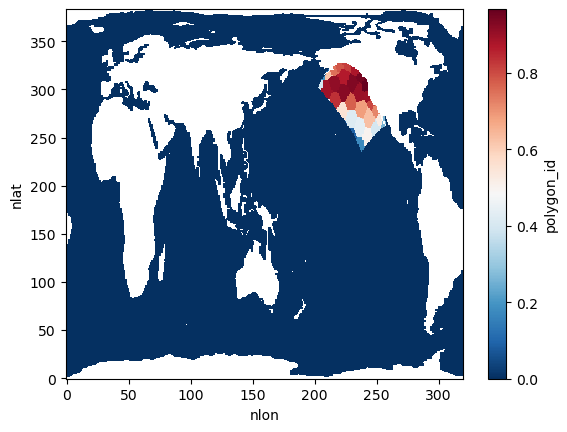

In [10]:
analyzer.set_field_within_boundaries(ds.fraction.isel(elapsed_time=-1)).plot(cmap="RdBu_r")
